In [11]:
from sklearn.metrics import precision_recall_fscore_support
from difflib import SequenceMatcher
from scripts.config import DefaultArgsNamespace
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn.metrics import average_precision_score, precision_recall_curve

args = DefaultArgsNamespace()

In [71]:
results_csv = './results/model_id_65184907_on_20241021-173928/preds.csv'
results_csv = './results/model_id_65185985_on_20241021-173559/preds.csv'


In [72]:
# get keysteps dict
keysteps_dict = args.dataloader_params['keysteps']
# Inverting the dictionary to map keystep_id to natural language description
keystep_id_to_desc = {i: v for i, v in enumerate(keysteps_dict.values())}

keysteps_dict = keystep_id_to_desc


In [73]:
from sklearn.metrics import average_precision_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
from difflib import SequenceMatcher

# Function to calculate edit score
def calculate_edit_score(ground_truth, predicted, edit_distance):
    max_len = max(len(ground_truth), len(predicted))
    if max_len == 0:  # To avoid division by zero
        return 1.0
    edit_score = 1 - (edit_distance / max_len)
    edit_score = np.round(edit_score, 4)
    return edit_score

# Function to calculate Levenshtein distance (edit distance)
def calculate_edit_distance(ground_truth, predicted):
    matcher = SequenceMatcher(None, ground_truth, predicted)
    edit_distance = sum(1 for opcode in matcher.get_opcodes() if opcode[0] != 'equal')
    edit_distance = np.round(edit_distance, 4)
    return edit_distance

# Function to calculate IoU for action sequences
def iou(ground_truth, predicted):
    intersection = len(set(ground_truth) & set(predicted))
    union = len(set(ground_truth) | set(predicted))
    return intersection / union if union > 0 else 0

# Function to calculate precision, recall, and F1 at IoU threshold
def calculate_f1_iou(ground_truth, predicted, threshold=0.5):
    iou_value = iou(ground_truth, predicted)
    if iou_value >= threshold:
        precision = precision_score(ground_truth, predicted, average='weighted', zero_division=0)
        recall = recall_score(ground_truth, predicted, average='weighted', zero_division=0)
        f1 = f1_score(ground_truth, predicted, average='weighted', zero_division=0)
    else:
        precision, recall, f1 = 0.0, 0.0, 0.0

    precision = np.round(precision, 4)
    recall = np.round(recall, 4)
    f1 = np.round(f1, 4)
    return precision, recall, f1

# Function to calculate AP for each action (keystep) and mAP
def calculate_ap_mAP(ground_truth, predicted, actions):
    aps = []
    for action in actions:
        # Convert the sequences into binary labels for each action
        true_binary = (np.array(ground_truth) == action).astype(int)
        pred_binary = (np.array(predicted) == action).astype(int)

        # Calculate Average Precision (AP)
        if np.sum(true_binary) > 0:  # Avoid calculating AP when no ground truth for action
            ap = average_precision_score(true_binary, pred_binary)
            aps.append(ap)
        else:
            aps.append(0.0)  # If no ground truth for this action, AP = 0

    # Calculate mean AP (mAP)
    mAP = np.mean(aps)
    return aps, mAP

# Function to calculate final average class-wise accuracy
def calculate_final_classwise_accuracy(all_ground_truth, all_predicted, actions):
    correct_predictions_per_class = {action: 0 for action in actions}
    total_samples_per_class = {action: 0 for action in actions}

    for ground_truth, predicted in zip(all_ground_truth, all_predicted):
        for action in actions:
            true_binary = np.array(ground_truth) == action
            pred_binary = np.array(predicted) == action
            
            correct_predictions = np.sum(true_binary & pred_binary)
            total_samples = np.sum(true_binary)

            correct_predictions_per_class[action] += correct_predictions
            total_samples_per_class[action] += total_samples

    # Calculate accuracy for each class
    classwise_accuracy = {}
    for action in actions:
        total_samples = total_samples_per_class[action]
        if total_samples > 0:
            classwise_accuracy[action] = np.round(correct_predictions_per_class[action] / total_samples, 4)
        else:
            classwise_accuracy[action] = 0.0  # If no samples for this class

    return classwise_accuracy

# Grouping by subject_id and trial_id
results = []
iou_thresholds = [0.0, 0.25, 0.50]

# Assuming 'results_csv' is defined earlier and points to the path of the results CSV
results_dir = results_csv.rsplit('/', 1)[0]

# Read CSV
df = pd.read_csv(results_csv)

# Assume keysteps_dict is provided in the context or passed as an argument
keystep_id_to_desc = {i: v for i, v in enumerate(keysteps_dict.values())}

# Adding keystep description to the dataframe
df['keystep_description'] = df['keystep_id'].map(keystep_id_to_desc)
df['pred_keystep_description'] = df['pred_keystep_id'].map(keystep_id_to_desc)

# Extract unique keysteps (actions) from ground truth and predicted
unique_actions = np.union1d(df['keystep_id'].unique(), df['pred_keystep_id'].unique())

# Lists to hold ground truth and predicted sequences for all trials
all_ground_truth = []
all_predicted = []

for (subject, trial), group in df.groupby(['subject_id', 'trial_id']):
    print("*"*50)
    print(f"Subject: {subject}, Trial: {trial}")
    
    # Extract ground truth and predicted keysteps
    ground_truth = group['keystep_id'].tolist()  # e.g., (0, 1, 2, 3, 3, 4, 5)
    predicted = group['pred_keystep_id'].tolist()  # e.g., (0, 1, 2, 3, 4, 5, 5)

    # Append ground truth and predicted to global lists
    all_ground_truth.append(ground_truth)
    all_predicted.append(predicted)

    # Calculate edit distance and edit score
    edit_distance = calculate_edit_distance(ground_truth, predicted)
    edit_score = calculate_edit_score(ground_truth, predicted, edit_distance)

    # Calculate metrics at various IoU thresholds
    metrics = {}
    for threshold in iou_thresholds:
        precision, recall, f1 = calculate_f1_iou(ground_truth, predicted, threshold=threshold)
        metrics[f'precision@IoU{threshold}'] = precision
        metrics[f'recall@IoU{threshold}'] = recall
        metrics[f'f1@IoU{threshold}'] = f1

    # Calculate AP and mAP for the action sequence
    aps, mAP = calculate_ap_mAP(ground_truth, predicted, unique_actions)

    # Append result
    results.append({
        'subject_id': subject,
        'trial_id': trial,
        'edit_distance': edit_distance,
        'edit_score': edit_score,
        **metrics,
        'ground_truth': ground_truth,
        'predicted': predicted,
        'mAP': mAP,  # mAP result
        'APs': aps,  # AP for each action
        'keystep_description': group['keystep_description'].tolist(),
        'pred_keystep_description': group['pred_keystep_description'].tolist()
    })
    print("*"*50)

# Calculate final class-wise accuracy across all trials
final_classwise_accuracy = calculate_final_classwise_accuracy(all_ground_truth, all_predicted, unique_actions)

# Save the final class-wise accuracy to CSV
classwise_accuracy_df = pd.DataFrame.from_dict(final_classwise_accuracy, orient='index', columns=['accuracy'])
classwise_accuracy_df['action_description'] = classwise_accuracy_df.index.map(keystep_id_to_desc)
classwise_accuracy_csv_path = f'{results_dir}/final_classwise_accuracy.csv'
classwise_accuracy_df.to_csv(classwise_accuracy_csv_path, index_label='action')

# Display the final class-wise accuracy DataFrame
classwise_accuracy_df.head()

# Save results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv(f'{results_dir}/detailed_results_with_map.csv', index=False)

# Calculate average metrics (excluding non-numeric columns)
average_metrics = results_df.drop(columns=['subject_id', 'trial_id', 'ground_truth', 'predicted', 'keystep_description', 'pred_keystep_description', 'APs']).mean()

# Convert the average metrics to a DataFrame row
average_metrics_df = pd.DataFrame(average_metrics).T

# Append the average metrics to the original results DataFrame
original_results = pd.read_csv(f'{results_dir}/metrics.csv')
final_df = pd.concat([original_results, average_metrics_df], axis=1)

# Save the final DataFrame with mAP
final_csv_path = f'{results_dir}/updated_metrics_with_map.csv'
final_df.to_csv(final_csv_path, index=False)

# Display the final DataFrame
final_df


**************************************************
Subject: ms1, Trial: 0
**************************************************
**************************************************
Subject: ms1, Trial: 5
**************************************************
**************************************************
Subject: ms2, Trial: 1
**************************************************
**************************************************
Subject: ng1, Trial: 0
**************************************************
**************************************************
Subject: ng2, Trial: 1
**************************************************
**************************************************
Subject: ng3, Trial: 0
**************************************************
**************************************************
Subject: ng3, Trial: 1
**************************************************
**************************************************
Subject: ng3, Trial: 9
**************************************************


,epoch,precision,recall,f1,accuracy,edit_distance,edit_score,precision@IoU0.0,recall@IoU0.0,f1@IoU0.0,precision@IoU0.25,recall@IoU0.25,f1@IoU0.25,precision@IoU0.5,recall@IoU0.5,f1@IoU0.5,mAP
0,0,0.471323,0.489909,0.42423,0.444159,5.272727,0.846695,0.4708,0.455405,0.416445,0.4708,0.455405,0.416445,0.461523,0.434655,0.404518,0.295078


In [ ]:
import matplotlib.cm as cm


# Function to generate a color map for keystep IDs with distinct colors, excluding red shades
def get_unique_colors(num_colors):
    # Use a base colormap (e.g., hsv)
    cmap = cm.get_cmap('tab20')  # Get 'num_colors' evenly spaced colors from the colormap
    
    # Generate the list of colors by sampling the colormap
    colors = [cmap(i / num_colors) for i in range(num_colors)]
    return colors

# Get unique colors for the number of keysteps
num_keysteps = len(keysteps_dict)
colors = get_unique_colors(num_keysteps)

# Create a color dictionary mapping keystep IDs to colors
keystep_color_dict = {keystep_id: colors[i] for i, keystep_id in enumerate(keysteps_dict.keys())}

# Output the dictionary for reference
keystep_color_dict


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

# Function to generate a color map for keystep IDs with distinct colors
def get_unique_colors(num_colors):
    return cm.get_cmap('tab20', num_colors)  # Using 'hsv' for distinct colors

# Function to plot keystep sequences with unique colors and a legend at the bottom
def plot_keystep_sequences(ground_truth, predicted, subject, trial, keystep_dict, results_dir):
    # Get unique keystep IDs for ground truth and predicted keysteps
    all_keysteps = list(set(ground_truth['keystep_id'].unique()).union(set(predicted['pred_keystep_id'].unique())))
    
    print(len(all_keysteps))
    # Generate a color map with as many unique colors as there are keysteps
    color_map = get_unique_colors(len(all_keysteps))
    color_dict = {keystep_id: color_map(i) for i, keystep_id in enumerate(all_keysteps)}

 
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(14, 5))  # Increased height and width for better spacing

    # Plot ground truth keysteps
    y_pos_gt = 0  # Position for ground truth timeline
    for i, (start, end, keystep_id) in enumerate(zip(ground_truth['start_frame'], ground_truth['end_frame'], ground_truth['keystep_id'])):
        width = max(end - start, 5)  # Ensure a minimum width for short keysteps
        rect = patches.Rectangle((start, y_pos_gt), width, 1, edgecolor=color_dict[keystep_id], facecolor=color_dict[keystep_id], linewidth=2, alpha=0.85)
        ax.add_patch(rect)

    # Plot predicted keysteps with mismatch highlighting
    y_pos_pred = 2  # Increased vertical space between ground truth and prediction
    for i, (start, end, pred_keystep_id) in enumerate(zip(predicted['start_frame'], predicted['end_frame'], predicted['pred_keystep_id'])):
        width = max(end - start, 5)  # Ensure a minimum width for short keysteps
        gt_keystep_id = ground_truth['keystep_id'].iloc[i] if i < len(ground_truth) else None
        if pred_keystep_id != gt_keystep_id:
            # Mismatch: use thicker red boundary
            rect = patches.Rectangle((start, y_pos_pred), width, 1, edgecolor='black', facecolor=color_dict[pred_keystep_id], linewidth=3, alpha=0.85)
            # print("Mismatch")
            # print(f"Predicted: {pred_keystep_id}, Ground Truth: {gt_keystep_id}, Start: {start}, End: {end}")
        else:
            # Match: use normal boundary color
            rect = patches.Rectangle((start, y_pos_pred), width, 1, edgecolor=color_dict[pred_keystep_id], facecolor=color_dict[pred_keystep_id], linewidth=2, alpha=0.85)
        ax.add_patch(rect)

    # Add labels for the timelines
    ax.text(-300, y_pos_gt + 0.5, 'Ground Truth', va='center', fontsize=10, color='blue')
    ax.text(-300, y_pos_pred + 0.5, 'Prediction', va='center', fontsize=10, color='red')

    # Create a horizontal legend at the bottom
    legend_elements = [patches.Patch(facecolor=color_dict[k], edgecolor=color_dict[k], label=f"{k}: {keystep_dict[k]}") for k in all_keysteps]
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=4, title="Keysteps")

    # Set axis limits and labels
    ax.set_xlim([0, max(ground_truth['end_frame'].max(), predicted['end_frame'].max())])
    ax.set_ylim([-1, 4])
    ax.set_xlabel('Frame Number')
    ax.set_title(f'Keystep Sequences for Subject {subject} Trial {trial}')

    # Hide y-axis
    ax.get_yaxis().set_visible(False)

    # hide top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # save figure
    plt.savefig(f'{plots_dir}/subject_{subject}_trial_{trial}_keystep_sequence.png', bbox_inches='tight')
    # Show plot
    # plt.tight_layout()
    # plt.show()





# Example usage with one subject's trial data
for (subject, trial), group in df.groupby(['subject_id', 'trial_id']):
    ground_truth_data = group[['keystep_id', 'start_frame', 'end_frame']]
    predicted_data = group[['pred_keystep_id', 'start_frame', 'end_frame']]

    plots_dir = f'{results_dir}/plots'
    os.makedirs(plots_dir, exist_ok=True)
    # save figure
    # Plot using the keystep IDs with unique colors, thicker boundaries, and a horizontal legend
    plot_keystep_sequences(ground_truth_data, predicted_data, subject, trial, keysteps_dict, plots_dir)
    # break  # Only plot the first subject's trial for now


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Function to generate a color map for keystep IDs with distinct colors
def get_unique_colors(num_colors):
    return cm.get_cmap('tab20', num_colors)  # Using 'hsv' for distinct colors

# Function to plot keystep sequences using horizontal bar plot
def plot_keystep_bars(ground_truth, predicted, subject, trial, keystep_dict, plots_dir):
    # Get unique keystep IDs for ground truth and predicted keysteps
    all_keysteps = list(set(ground_truth['keystep_id'].unique()).union(set(predicted['pred_keystep_id'].unique())))
    
    # Generate a color map with as many unique colors as there are keysteps
    color_map = get_unique_colors(len(all_keysteps))
    color_dict = {keystep_id: color_map(i) for i, keystep_id in enumerate(all_keysteps)}

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 7))  # Increased height for better spacing

    # Plot horizontal bars for ground truth keysteps
    y_pos_gt = 0  # Position for ground truth timeline
    for i, (start, end, keystep_id) in enumerate(zip(ground_truth['start_frame'], ground_truth['end_frame'], ground_truth['keystep_id'])):
        width = max(end - start, 5)  # Ensure a minimum width of 5 for visibility
        ax.barh(y_pos_gt, width, left=start, height=0.6, color=color_dict[keystep_id], edgecolor='black',  linewidth=0.25)
        y_pos_gt += 1  # Move to next row for ground truth

    # Plot horizontal bars for predicted keysteps
    y_pos_pred = y_pos_gt + 1  # Leave a gap between ground truth and predicted
    for i, (start, end, pred_keystep_id) in enumerate(zip(predicted['start_frame'], predicted['end_frame'], predicted['pred_keystep_id'])):
        width = max(end - start, 5)  # Ensure a minimum width of 5 for visibility
        if pred_keystep_id != ground_truth['keystep_id'].iloc[i]:
            ax.barh(y_pos_pred, width, left=start, height=0.6, color=color_dict[pred_keystep_id], edgecolor='black', linewidth=2, hatch='//')  # Highlight mismatches
            # ax.barh(y_pos_pred, width, left=start, height=0.6, color=color_dict[pred_keystep_id], edgecolor='black', linewidth=2)  # Highlight mismatches

        else:
            ax.barh(y_pos_pred, width, left=start, height=0.6, color=color_dict[pred_keystep_id], edgecolor='black', linewidth=0.25)
        y_pos_pred += 1  # Move to next row for predicted

    # Create a horizontal legend at the bottom
    legend_elements = [plt.Line2D([0], [0], color=color_dict[k], lw=4, label=f"{k}: {keystep_dict[k]}") for k in all_keysteps]
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=4, title="Keysteps")

    # Add labels for the timelines
    ax.text(-300, y_pos_gt - 7, 'Ground Truth', va='center', fontsize=10, color='blue')
    ax.text(-300, y_pos_pred - 6, 'Prediction', va='center', fontsize=10, color='red')

    # hide top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)


    # Set axis limits and labels
    ax.set_xlim([0, max(ground_truth['end_frame'].max(), predicted['end_frame'].max())])
    ax.set_yticks([])  # Hide y-axis labels
    ax.set_xlabel('Frame Number')
    ax.set_title(f'Keystep Sequences for Subject {subject} Trial {trial}')

    # save figure
    plt.savefig(f'{plots_dir}/subject_{subject}_trial_{trial}_keystep_bars.png', bbox_inches='tight')
    # Show plot
    # plt.tight_layout()
    # plt.show()


df = pd.read_csv(results_csv)

keysteps_dict = args.dataloader_params['keysteps']
print(keysteps_dict)

# Inverting the dictionary to map keystep_id to natural language description
keystep_id_to_desc = {i: v for i, v in enumerate(keysteps_dict.values())}

# Adding a new column to the dataframe that maps keystep_id to the corresponding natural language description
df['keystep_description'] = df['keystep_id'].map(keystep_id_to_desc)
df['pred_keystep_description'] = df['pred_keystep_id'].map(keystep_id_to_desc)

# Display the updated dataframe
df.head()

# get keysteps dict
keysteps_dict = args.dataloader_params['keysteps']
# Inverting the dictionary to map keystep_id to natural language description
keystep_id_to_desc = {i: v for i, v in enumerate(keysteps_dict.values())}

keysteps_dict = keystep_id_to_desc

# Example usage with one subject's trial data
for (subject, trial), group in df.groupby(['subject_id', 'trial_id']):
    ground_truth_data = group[['keystep_id', 'start_frame', 'end_frame']]
    predicted_data = group[['pred_keystep_id', 'start_frame', 'end_frame']]

    plots_dir = f'{results_dir}/plots/bar_plots'
    os.makedirs(plots_dir, exist_ok=True)
    # Plot using the keystep IDs with horizontal bar plot and color legend
    plot_keystep_bars(ground_truth_data, predicted_data, subject, trial, keysteps_dict, plots_dir)
    # break  # Only plot the first subject's trial for now


## Detail result plot


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample data from the table
data = {
    'Model': ['ICRA Model']*18,
    'Modality': ['Video (Resnet50)']*6 + ['I3D (RGB,Flow)']*6 + ['IMU (Smartwatch)']*6,
    'Window': ['4s']*3 + ['Full']*3 + ['4s']*3 + ['Full']*3 + ['4s']*3 + ['Full']*3,
    'IOU': ['0', '0.25', '0.5']*6,
    'Precision': [0.658, 0.658, 0.567, 0.644, 0.640, 0.625, 
                  0.663, 0.663, 0.636, 0.661, 0.661, 0.651, 
                  0.556, 0.556, 0.528, 0.490, 0.490, 0.457],
    'Recall': [0.701, 0.701, 0.594, 0.683, 0.670, 0.651, 
               0.715, 0.715, 0.674, 0.703, 0.703, 0.687, 
               0.614, 0.614, 0.584, 0.551, 0.551, 0.507],
    'F1-score': [0.659, 0.659, 0.565, 0.641, 0.634, 0.619, 
                 0.672, 0.672, 0.640, 0.662, 0.662, 0.651, 
                 0.571, 0.571, 0.542, 0.500, 0.500, 0.464],
    'Accuracy': [0.700, 0.700, 0.700, 0.680, 0.680, 0.680,
                 0.711, 0.711, 0.711, 0.701, 0.701, 0.701,
                 0.603, 0.603, 0.603, 0.562, 0.562, 0.562],
    'Edit Score': [0.862, 0.862, 0.862, 0.798, 0.798, 0.798,
                   0.865, 0.865, 0.865, 0.810, 0.810, 0.810,
                   0.839, 0.839, 0.839, 0.753, 0.753, 0.753],
    'Edit Distance': [4.909, 4.909, 4.909, 3.955, 3.955, 3.955,
                      4.909, 4.909, 4.909, 3.682, 3.682, 3.682,
                      5.591, 5.591, 5.591, 4.591, 4.591, 4.591]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Set plot style
sns.set_theme(style="whitegrid", palette=sns.color_palette("hls", 3))


# Plot 1: Precision for each modality and window size
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='IOU', y='Precision', hue='Modality', style='Window', markers=True, linewidth=1.5, markersize=10)
plt.title('Precision vs IOU')
plt.xlabel('IOU')
plt.ylabel('Precision')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=7)
plt.savefig(f'{results_dir}/plots/precision_vs_iou.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

# Plot 2: Recall for each modality and window size
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='IOU', y='Recall', hue='Modality', style='Window', markers=True)
plt.title('Recall vs IOU')
plt.xlabel('IOU')
plt.ylabel('Recall')
plt.legend( loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=7)
plt.savefig(f'{results_dir}/plots/recall_vs_iou.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

# Plot 3: F1-score for each modality and window size
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='IOU', y='F1-score', hue='Modality', style='Window', markers=True)
plt.title('F1-score vs IOU')
plt.xlabel('IOU')
plt.ylabel('F1-score')
plt.legend( loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=7)
plt.savefig(f'{results_dir}/plots/f1_score_vs_iou.png', bbox_inches='tight')
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample data from the table
data = {
    'Model': ['ICRA Model']*18,
    'Modality': ['Video (Resnet50)']*6 + ['I3D (RGB,Flow)']*6 + ['IMU (Smartwatch)']*6,
    'Window': ['4s']*3 + ['Full']*3 + ['4s']*3 + ['Full']*3 + ['4s']*3 + ['Full']*3,
    'IOU': ['0', '0.25', '0.5']*6,
    'Precision': [0.658, 0.658, 0.567, 0.644, 0.640, 0.625, 
                  0.663, 0.663, 0.636, 0.661, 0.661, 0.651, 
                  0.556, 0.556, 0.528, 0.490, 0.490, 0.457],
    'Recall': [0.701, 0.701, 0.594, 0.683, 0.670, 0.651, 
               0.715, 0.715, 0.674, 0.703, 0.703, 0.687, 
               0.614, 0.614, 0.584, 0.551, 0.551, 0.507],
    'F1-score': [0.659, 0.659, 0.565, 0.641, 0.634, 0.619, 
                 0.672, 0.672, 0.640, 0.662, 0.662, 0.651, 
                 0.571, 0.571, 0.542, 0.500, 0.500, 0.464],
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Set plot style
sns.set_theme(style="whitegrid", palette=sns.color_palette("hls", 3))

# Create a figure with three subplots horizontally
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Precision vs IOU
sns.lineplot(data=df, x='IOU', y='Precision', hue='Modality', style='Window', markers=True, linewidth=1.5, markersize=10, ax=axes[0])
axes[0].set_title('Precision vs IOU')
axes[0].set_xlabel('IOU')
axes[0].set_ylabel('Precision')

# Plot 2: Recall vs IOU
sns.lineplot(data=df, x='IOU', y='Recall', hue='Modality', style='Window', markers=True, linewidth=1.5, markersize=10, ax=axes[1])
axes[1].set_title('Recall vs IOU')
axes[1].set_xlabel('IOU')
axes[1].set_ylabel('Recall')

# Plot 3: F1-score vs IOU
sns.lineplot(data=df, x='IOU', y='F1-score', hue='Modality', style='Window', markers=True, linewidth=1.5, markersize=10, ax=axes[2])
axes[2].set_title('F1-score vs IOU')
axes[2].set_xlabel('IOU')
axes[2].set_ylabel('F1-score')

# Remove legends from individual plots
axes[0].legend_.remove()
axes[1].legend_.remove()
axes[2].legend_.remove()

# Create a single legend for the entire figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=8)

plt.savefig(f'{results_dir}/plots/metrics_vs_iou.png', bbox_inches='tight')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the legend
plt.show()



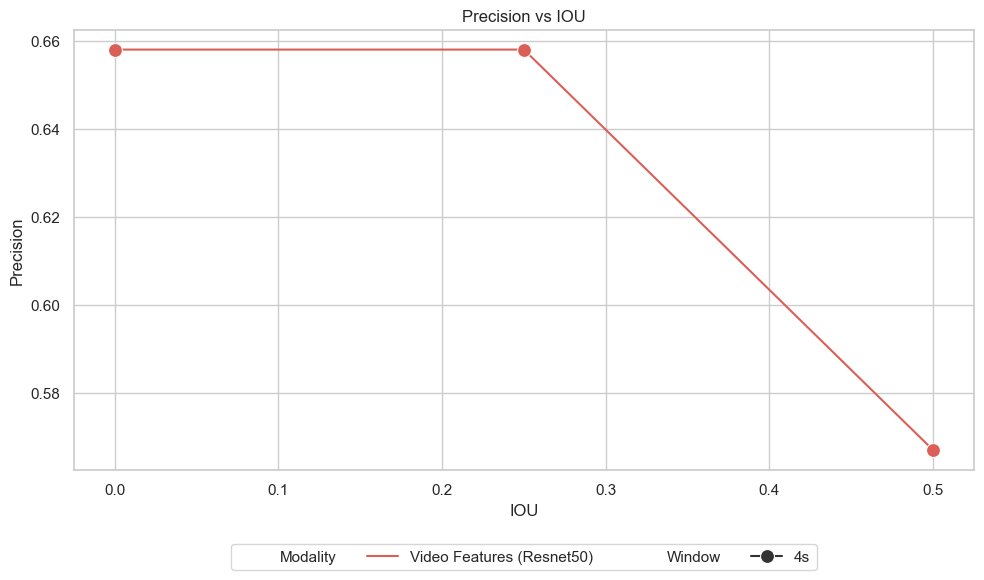

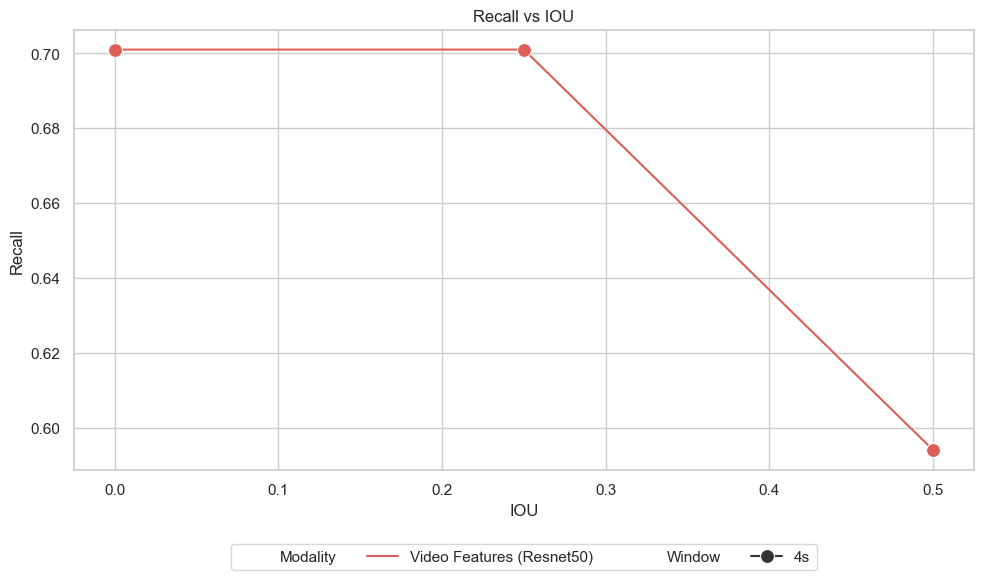

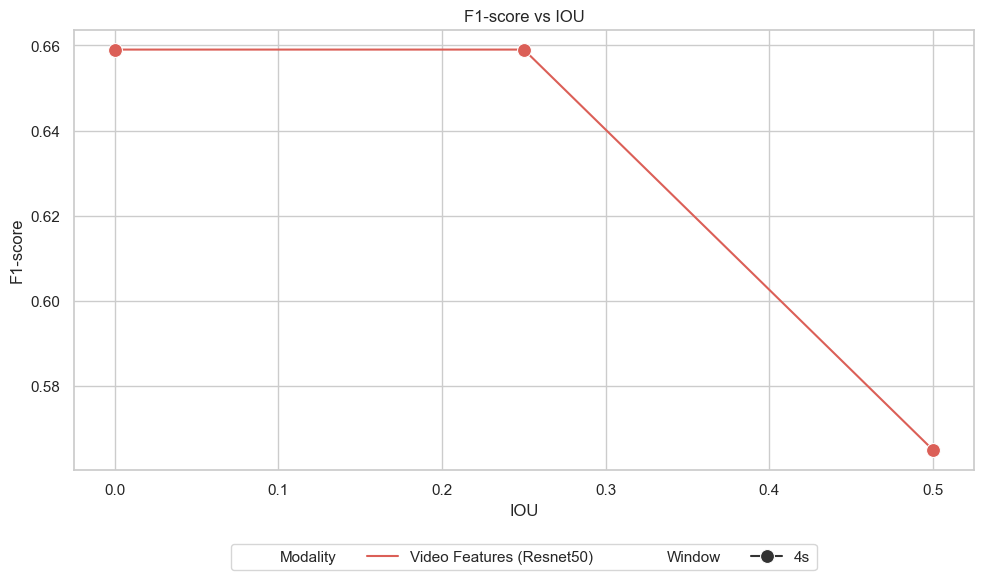

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Flatten the JSON structure into a DataFrame (same as before)
rows = []
for model in data["model"]:
    for exp in model["experiments"]:
        if "iou_results" in exp:
            for iou_result in exp["iou_results"]:
                rows.append({
                    "Model": model["model_name"],
                    "Modality": exp["modality"],
                    "Window": exp["window_size"],
                    "IOU": iou_result["iou"],
                    **iou_result["results"]
                })
        else:
            rows.append({
                "Model": model["model_name"],
                "Modality": exp["modality"],
                "Window": exp["window_size"],
                "IOU": "N/A",
                **exp["results"]
            })

# Convert to DataFrame
df = pd.DataFrame(rows)

# Replace 'N/A' with np.nan
df.replace("N/A", np.nan, inplace=True)

# Now, ensure numeric columns can be properly converted to float
df["IOU"] = pd.to_numeric(df["IOU"], errors='coerce')

# Now you can handle NaN in several ways
# For example, you can drop rows with NaN IOU values or other missing numeric values
df.dropna(subset=['IOU'], inplace=True)

# Set plot style
sns.set_theme(style="whitegrid", palette=sns.color_palette("hls", 3))

# Plot 1: Precision for each modality and window size
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='IOU', y='precision', hue='Modality', style='Window', markers=True, linewidth=1.5, markersize=10)
plt.title('Precision vs IOU')
plt.xlabel('IOU')
plt.ylabel('Precision')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=7)
plt.savefig(f'{results_dir}/precision_vs_iou.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

# Plot 2: Recall for each modality and window size
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='IOU', y='recall', hue='Modality', style='Window', markers=True, linewidth=1.5, markersize=10)
plt.title('Recall vs IOU')
plt.xlabel('IOU')
plt.ylabel('Recall')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=7)
plt.savefig(f'{results_dir}/recall_vs_iou.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

# Plot 3: F1-score for each modality and window size
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='IOU', y='f1', hue='Modality', style='Window', markers=True, linewidth=1.5, markersize=10)
plt.title('F1-score vs IOU')
plt.xlabel('IOU')
plt.ylabel('F1-score')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=7)
plt.savefig(f'{results_dir}/f1_score_vs_iou.png', bbox_inches='tight')
plt.tight_layout()
plt.show()
